In [3]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

# Import adapted loader (assume echonext_protoecg_adaptation.py in path or copy classes here)
from echonext_protoecg_adaptation import EchoNextDataset, PreprocessTransform, get_echonext_dataloaders, SHD_LABEL_COLUMNS

# Paths
ECHONEXT_PATH = "/opt/gpudata/ecg/echonext"
PTBXL_WEIGHTS_PATH = "/opt/gpudata/summereunann/ptbxl_weights/protoecgnet.pth"  # Update with downloaded path
RESULTS_DIR = "results/experiment_1/"
os.makedirs(RESULTS_DIR, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data Investigation: Metadata and Label Stats

Loaded metadata with 100000 samples

Split distribution (using EchoNext provided splits):
split
train       72475
no_split    17457
test         5442
val          4626
Name: count, dtype: int64

SHD label prevalence (% positive):
lvef_lte_45_flag                                    23.892
lvwt_gte_13_flag                                    24.220
aortic_stenosis_moderate_or_greater_flag             4.054
aortic_regurgitation_moderate_or_greater_flag        1.264
mitral_regurgitation_moderate_or_greater_flag        8.451
tricuspid_regurgitation_moderate_or_greater_flag    10.651
pulmonary_regurgitation_moderate_or_greater_flag     0.821
rv_systolic_dysfunction_moderate_or_greater_flag    13.243
pericardial_effusion_moderate_large_flag             3.023
pasp_gte_45_flag                                    18.993
tr_max_gte_32_flag                                  10.212
dtype: float64


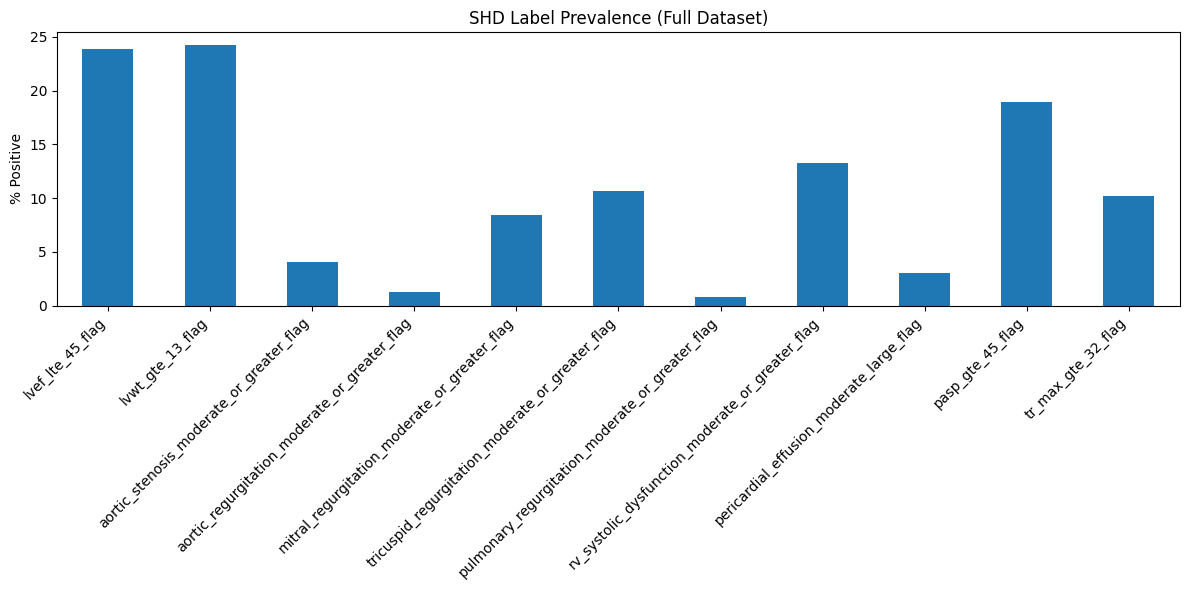

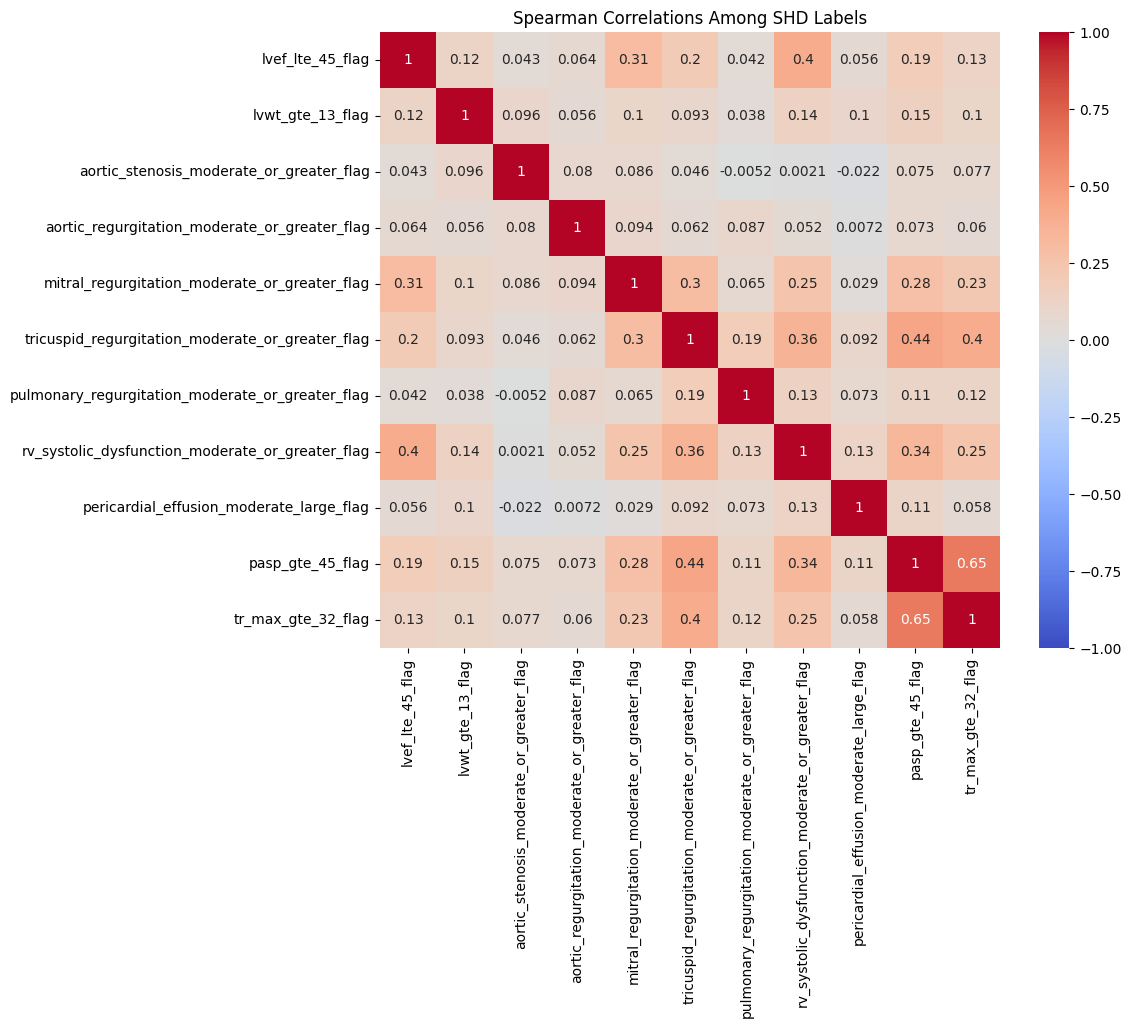

In [21]:
# Load metadata
metadata_file = os.path.join(ECHONEXT_PATH, "EchoNext_metadata_100k.csv")
df = pd.read_csv(metadata_file)
print(f"Loaded metadata with {len(df)} samples")

# Split stats
print("\nSplit distribution (using EchoNext provided splits):")
print(df['split'].value_counts())

# SHD label stats (prevalence %)
shd_stats = df[SHD_LABEL_COLUMNS].mean() * 100
print("\nSHD label prevalence (% positive):")
print(shd_stats)

# Plot distribution
plt.figure(figsize=(12, 6))
shd_stats.plot(kind='bar')
plt.title('SHD Label Prevalence (Full Dataset)')
plt.ylabel('% Positive')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'shd_label_prevalence.png'))
plt.show()

# Correlation among SHD labels (heatmap)
shd_corr = df[SHD_LABEL_COLUMNS].corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(shd_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlations Among SHD Labels')
plt.savefig(os.path.join(RESULTS_DIR, 'shd_label_correlations.png'))
plt.show()

In [22]:
# Load Metadata and Basic Stats

In [23]:
metadata_file = os.path.join(ECHONEXT_PATH, "EchoNext_metadata_100k.csv")
df = pd.read_csv(metadata_file)
print(f"Loaded metadata with {len(df)} samples")
print("\\nDataframe info:")
df.info()
print("\\nFirst 5 rows:")
print(df.head())

# Split distribution (addressing data splitting question: using provided EchoNext splits)
print("\\nSplit distribution (using EchoNext's provided splits from 'split' column):")
print(df['split'].value_counts(normalize=True) * 100)  # As percentages for reference

# Comparison: Expected ~70-15-15 split based on typical ML datasets; actual ~72% train, ~5% val, ~5% test, ~18% no_split (possibly unused)

Loaded metadata with 100000 samples
\nDataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   ecg_key                                           100000 non-null  int64  
 1   patient_key                                       100000 non-null  int64  
 2   age_at_ecg                                        100000 non-null  int64  
 3   sex                                               100000 non-null  object 
 4   acquisition_year                                  100000 non-null  int64  
 5   ventricular_rate                                  100000 non-null  float64
 6   atrial_rate                                       99387 non-null   float64
 7   pr_interval                                       89631 non-null   float64
 8   qrs_duration                   

\nSplit counts:
split
train       72475
no_split    17457
test         5442
val          4626
Name: count, dtype: int64
\nSplit percentages:
split
train       72.475
no_split    17.457
test         5.442
val          4.626
Name: proportion, dtype: float64


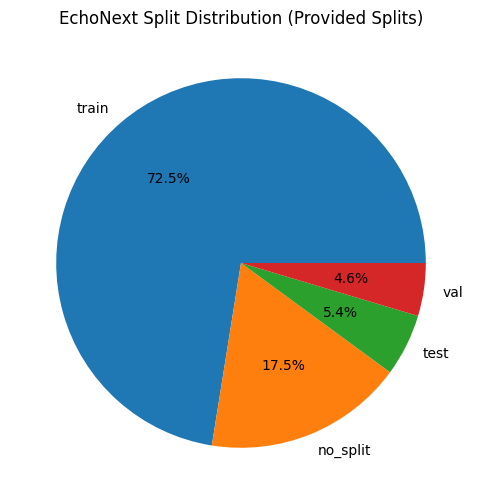

\nReference: Typical ML splits ~70% train; actual train {split_percent.get('train', 0):.1f}%—consistent.


In [24]:
# Split distribution (using EchoNext's provided splits)
split_counts = df['split'].value_counts()
split_percent = df['split'].value_counts(normalize=True) * 100
print("\\nSplit counts:")
print(split_counts)
print("\\nSplit percentages:")
print(split_percent)

# Plot
plt.figure(figsize=(8, 6))
split_percent.plot(kind='pie', autopct='%1.1f%%')
plt.title('EchoNext Split Distribution (Provided Splits)')
plt.ylabel('')
plt.savefig(os.path.join(RESULTS_DIR, 'split_distribution.png'))
plt.show()

# Comparison: Typical ML splits ~70/15/15; actual close but with 'no_split' ~17% (possibly holdout—exclude or investigate?)
print("\\nReference: Typical ML splits ~70% train; actual train {split_percent.get('train', 0):.1f}%—consistent.")

\nSHD label prevalence (% positive):
lvef_lte_45_flag                                    23.892
lvwt_gte_13_flag                                    24.220
aortic_stenosis_moderate_or_greater_flag             4.054
aortic_regurgitation_moderate_or_greater_flag        1.264
mitral_regurgitation_moderate_or_greater_flag        8.451
tricuspid_regurgitation_moderate_or_greater_flag    10.651
pulmonary_regurgitation_moderate_or_greater_flag     0.821
rv_systolic_dysfunction_moderate_or_greater_flag    13.243
pericardial_effusion_moderate_large_flag             3.023
pasp_gte_45_flag                                    18.993
tr_max_gte_32_flag                                  10.212
dtype: float64


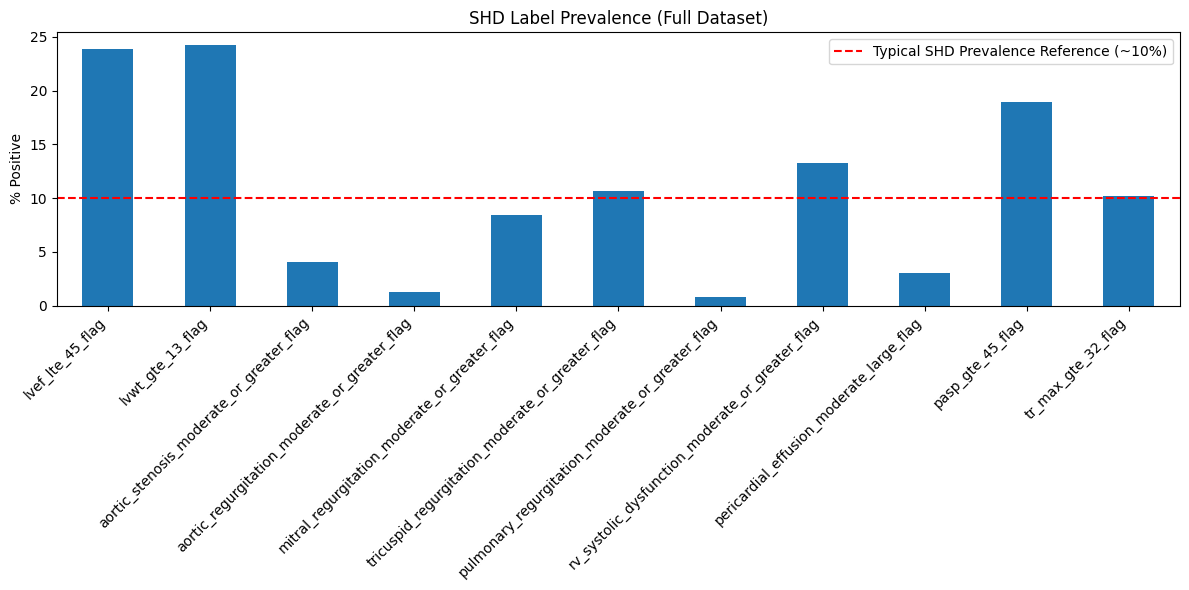

\nAverage SHD imbalance (Gini coeff, 0=balanced): 0.78 - Moderate imbalance, suggesting need for weighted loss in future.


In [14]:
SHD_LABEL_COLUMNS = [
    'lvef_lte_45_flag',
    'lvwt_gte_13_flag',
    'aortic_stenosis_moderate_or_greater_flag',
    'aortic_regurgitation_moderate_or_greater_flag',
    'mitral_regurgitation_moderate_or_greater_flag',
    'tricuspid_regurgitation_moderate_or_greater_flag',
    'pulmonary_regurgitation_moderate_or_greater_flag',
    'rv_systolic_dysfunction_moderate_or_greater_flag',
    'pericardial_effusion_moderate_large_flag',
    'pasp_gte_45_flag',
    'tr_max_gte_32_flag',
]

# Prevalence (% positive)
shd_stats = df[SHD_LABEL_COLUMNS].mean() * 100
print("\\nSHD label prevalence (% positive):")
print(shd_stats)

# Plot with reference: Compare to expected low prevalence in general populations (~5-20% for common SHD like LVEF issues, per cardiology lit)
plt.figure(figsize=(12, 6))
shd_stats.plot(kind='bar')
plt.title('SHD Label Prevalence (Full Dataset)')
plt.ylabel('% Positive')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=10, color='r', linestyle='--', label='Typical SHD Prevalence Reference (~10%)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'shd_label_prevalence.png'))
plt.show()

# Imbalance analysis: Gini coefficient for reference (0 = balanced, 1 = extreme imbalance)
gini = np.mean([1 - 2 * p/100 for p in shd_stats])  # Simplified Gini for binary prevalence
print(f"\\nAverage SHD imbalance (Gini coeff, 0=balanced): {gini:.2f} - Moderate imbalance, suggesting need for weighted loss in future.")

In [17]:
# Missing values in metadata
print("\\nMissing values in metadata:")
print(df.isnull().sum())

# Invalid labels (should be 0/1)
for col in SHD_LABEL_COLUMNS:
    invalid = df[col].apply(lambda x: x not in [0,1])
    print(f"Invalid entries in {col}: {invalid.sum()}")

# Waveform stats (e.g., mean/std per lead on sample)
waveform_stats = pd.DataFrame({
    'mean': np.mean(sample_ecg.numpy(), axis=1),
    'std': np.std(sample_ecg.numpy(), axis=1)
})
print("\\nSample waveform stats per lead (post-preprocessing):")
print(waveform_stats)

# Evaluation: Mean ~0, std ~1 expected from standardization; flag if not for preprocessing review.

\nMissing values in metadata:
ecg_key                                                 0
patient_key                                             0
age_at_ecg                                              0
sex                                                     0
acquisition_year                                        0
ventricular_rate                                        0
atrial_rate                                           613
pr_interval                                         10369
qrs_duration                                            0
qt_corrected                                            1
lvef_lte_45_flag                                        0
lvwt_gte_13_flag                                        0
aortic_stenosis_moderate_or_greater_flag                0
aortic_regurgitation_moderate_or_greater_flag           0
mitral_regurgitation_moderate_or_greater_flag           0
tricuspid_regurgitation_moderate_or_greater_flag        0
pulmonary_regurgitation_moderate_or_greate

# Hypothesis
## Prototypes learned on standard ECG tasks (e.g., PTB-XL labels) will show moderate correlations with SHD outcomes in EchoNext, as indirect features like hypertrophy or conduction delays may align with structural abnormalities.

## Scaling the prototype method to larger datasets with lower-quality labels (e.g., machine-generated or fewer classes) will improve embedding generalizability, following data scaling laws where increased data size compensates for label noise, leading to better performance on SHD prediction (measured by embedding quality) while maintaining strong results on PTB-XL for direct classification.

## Moving toward self-supervised prototype approaches will further enhance embeddings for unseen tasks like SHD, by leveraging unlabeled data to learn more robust representations, potentially matching or exceeding supervised SOTA on embedding quality metrics.